# **Creating a naive bayes model to predict if a movie is a "hit" or "flop"**

Since our dataset has no predicting column yet we will need to create one. We need to figure out how we want to define "hit" or "flop".

The columns in dataset:
*   score
*   genre
*   overview
*   crew
*   original language
*   budget_x
*   revenue
*   country
*   names, orig_titles, status, etc.

We will use a combined rule that captures both financial and audience sucess:

HIT if BOTH are true:


1.   ROI ≥ 1.3
(meaning: revenue ≥ 1.3 × budget → profitable)
2.   score ≥ 70
(equivalent to IMDb ~7.0)

Otherwise → FLOP



In [ ]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import files
uploaded = files.upload()

movies_df = pd.read_csv('imdb_movies.csv')
movies_df.head()

Saving imdb_movies.csv to imdb_movies.csv


,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


**Information on the dataset**

In [ ]:
print(f"Shape of the dataset: {movies_df.shape}")

print("\nColumns in the dataset")
print(movies_df.columns)

print("\nChecking for missing values in the dataset")
print(movies_df.info())

Shape of the dataset: (10178, 12)

Columns in the dataset
Index(['names', 'date_x', 'score', 'genre', 'overview', 'crew', 'orig_title',
       'status', 'orig_lang', 'budget_x', 'revenue', 'country'],
      dtype='object')

Checking for missing values in the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+

**Clean the dataset**

Checking to see if there are any nulls because machine learning models cannot train on missing values

In [ ]:
print(movies_df.isnull())

       names  date_x  score  genre  overview   crew  orig_title  status  \
0      False   False  False  False     False  False       False   False   
1      False   False  False  False     False  False       False   False   
2      False   False  False  False     False  False       False   False   
3      False   False  False  False     False  False       False   False   
4      False   False  False  False     False  False       False   False   
...      ...     ...    ...    ...       ...    ...         ...     ...   
10173  False   False  False  False     False  False       False   False   
10174  False   False  False  False     False  False       False   False   
10175  False   False  False  False     False  False       False   False   
10176  False   False  False  False     False  False       False   False   
10177  False   False  False  False     False  False       False   False   

       orig_lang  budget_x  revenue  country  
0          False     False    False    False  
1    

In [ ]:
print(movies_df.isnull().sum())

names          0
date_x         0
score          0
genre         85
overview       0
crew          56
orig_title     0
status         0
orig_lang      0
budget_x       0
revenue        0
country        0
dtype: int64


Checking to see if some movies have a budget of 0 cause these ones will corrupt the model.

In [ ]:
movies_df[movies_df['budget_x'] == 0]

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country


**Data Transformation**

Only want the dataset to have numerical features because naive bayes cannot run with categorical features

In [ ]:
movies_df = movies_df.dropna(subset=['budget_x', 'revenue', 'score'])
movies_df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
genre_encoded = enc.fit_transform(movies_df[['genre']])

**Create dependent varaible**

This varaible will be the output we are predicting

1 → hit = revenue > budget

0 → flop = revenue <= budget

1.   ROI ≥ 1.3
(meaning: revenue ≥ 1.3 × budget → profitable)
2.   score ≥ 70
(equivalent to IMDb ~7.0)

In [ ]:
movies_df['ROI'] = movies_df['revenue'] / movies_df['budget_x']
movies_df['hit_flop'] = ((movies_df['ROI'] >= 1.3) & (movies_df['score'] >= 70)).astype(int)
movies_df['hit_flop'] = movies_df['hit_flop'].replace({1: 'hit', 0: 'flop'})
movies_df['hit_flop'].value_counts()

#####
#movies_df['hit_flop'] = (movies_df['revenue'] > movies_df['budget_x']).astype(int)

#movies_df['hit_flop'] = movies_df['hit_flop'].replace({1: 'hit', 0: 'flop'})
#movies_df['hit_flop'].value_counts()

,count
hit_flop,
flop,7455
hit,2723


In [ ]:
movies_df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,hit_or_flop,hit_flop,ROI
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU,1,hit,3.621556
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU,1,hit,5.036511
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU,1,hit,7.244590
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU,1,hit,2.780488
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US,1,flop,4.427818


,count
hit_flop,
flop,7455
hit,2723


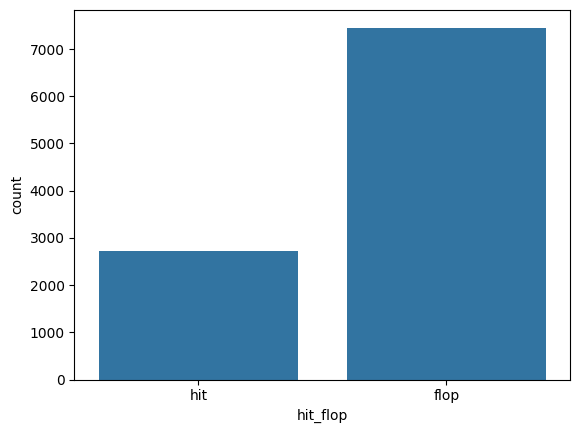

In [ ]:
sns.countplot(x='hit_flop', data=movies_df)
movies_df.loc[:, "hit_flop"].value_counts()

**Naive Bayes Implementation**

We will be using gaussian naive bayes beccause it is for continous numerical features which is what we have in our dataset.

In [ ]:
X = np.hstack([
    movies_df[['score', 'budget_x']].values,  # numeric features
    genre_encoded                      # encoded genre
])

y = movies_df['hit_flop'].values

In [ ]:
RANDOM_STATE = 42

#X = movies_df.drop(columns=['hit_flop'])
#y = movies_df['hit_flop']

# Train/test: 80/20 (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print('Shapes:')
print('  Train:', X_train.shape, y_train.shape)
print('  Test: ', X_test.shape, y_test.shape)

Shapes:
  Train: (8142, 2306) (8142,)
  Test:  (2036, 2306) (2036,)


In [ ]:
from sklearn.naive_bayes import GaussianNB

#build a MultinomialNB
model = GaussianNB()

#Model training -- model.fit() is used to make predictions using given data i.e. it fits/maps the given data to the model
#creating the contingency probability table

model.fit(X_train, y_train)

print("Train data accuracy of Multinomial NBC algo:", model.score(X_train, y_train))
print("Test data accuracy of Multinomial NBC algo:", model.score(X_test, y_test))

Train data accuracy of Multinomial NBC algo: 0.7326209776467698
Test data accuracy of Multinomial NBC algo: 0.731335952848723


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report")
print(classification_report(y_test, model.predict(X_test)))

Classification Report
              precision    recall  f1-score   support

        flop       0.73      1.00      0.84      1491
         hit       0.25      0.00      0.00       545

    accuracy                           0.73      2036
   macro avg       0.49      0.50      0.42      2036
weighted avg       0.60      0.73      0.62      2036



In [ ]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Confusion Matrix
[[1488    3]
 [ 544    1]]


Analysis

1488 → flops correctly predicted as flops

3 → flops incorrectly predicted as hits

544 → hits incorrectly predicted as flops

1 → hit correctly predicted as hits

accuracy: is 73%

Conclusion:
*   model strongly predicts flops, but struggles to predict hits because hits are a minority in the dataset.
*   very low recall for hits because the dataset is imbalanced
*   This is normal for box-office datasets since most movies do flop





Will be using SMOTE to balance the dataset so the classifer learns hits better.

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
RANDOM_STATE = 42

X = X_train_resampled
y = y_train_resampled

from sklearn.naive_bayes import GaussianNB

#build a MultinomialNB
model = GaussianNB()

#Model training -- model.fit() is used to make predictions using given data i.e. it fits/maps the given data to the model
#creating the contingency probability table

model.fit(X, y)

#print("Train data accuracy of Multinomial NBC algo:", model.score(X_train, y_train))
#print("Test data accuracy of Multinomial NBC algo:", model.score(X_test, y_test))

GaussianNB()

In [ ]:
print("Classification Report")
print(classification_report(y_test, model.predict(X_test)))

Classification Report
              precision    recall  f1-score   support

        flop       0.75      0.71      0.73      1491
         hit       0.31      0.36      0.33       545

    accuracy                           0.62      2036
   macro avg       0.53      0.53      0.53      2036
weighted avg       0.63      0.62      0.62      2036



In [ ]:
print("Confusion Matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Confusion Matrix
[[1058  433]
 [ 349  196]]


Analysis

1058 → flops correctly predicted as flops

433 → flops incorrectly predicted as hits

349 → hits incorrectly predicted as flops

196 → hit correctly predicted as hits

Accuracy: 62%

Comparison from previous model:
* Compared to the previous model, this one predicts hits much better (from 1 → 196)
* however, it misclassifies more flops as hits (from 3 → 433) which is expected since SMOTE forces the model to treat hits and flops equally as important.
* so the model learns hits better, but it makes more mistakes on flops

In [ ]:
print(movies_df.iloc[1])

names                                   Avatar: The Way of Water
date_x                                               12/15/2022 
score                                                       78.0
genre                         Science Fiction, Adventure, Action
overview       Set more than a decade after the events of the...
crew           Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...
orig_title                              Avatar: The Way of Water
status                                                  Released
orig_lang                                                English
budget_x                                             460000000.0
revenue                                             2316794914.0
country                                                       AU
hit_or_flop                                                    1
hit_flop                                                     hit
ROI                                                     5.036511
Name: 1, dtype: object


add new data to test the model